In [1]:
import numpy as np
import matplotlib.pyplot as plt

#eval = np.load('./logs/4_actions/train_90_eval_99/evaluations.npz')
#eval = np.load('./logs/4_actions/train_eval_eq_90/evaluations.npz')
#eval = np.load('./logs/8_actions/train_90_eval_95/evaluations.npz')
eval = np.load('./logs/evaluations.npz')


[[1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 100

Text(0, 0.5, 'Episode Length')

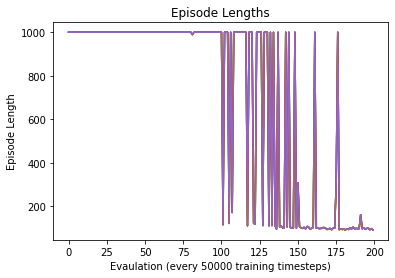

In [2]:
print(eval['ep_lengths'])
plt.figure()
plt.plot(eval['ep_lengths'])
plt.title('Episode Lengths')
plt.xlabel('Evaulation (every 50000 training timesteps)')
plt.ylabel('Episode Length')

In [3]:
# keys are :['ep_lengths', 'results', 'timesteps']

[[  -34730.   -34730.   -34730.   -34730.   -34730.]
 [  -34460.   -34460.   -34460.   -34460.   -34460.]
 [  -34490.   -34490.   -34490.   -34490.   -34490.]
 [  -34730.   -34730.   -34730.   -34730.   -34730.]
 [  -34730.   -34730.   -34730.   -34730.   -34730.]
 [  -34730.   -34730.   -34730.   -34730.   -34730.]
 [  -34490.   -34490.   -34490.   -34490.   -34490.]
 [  -34490.   -34490.   -34490.   -34490.   -34490.]
 [  -34850.   -34850.   -34850.   -34850.   -34850.]
 [  -34760.   -34760.   -34760.   -34760.   -34760.]
 [  -34730.   -34730.   -34730.   -34730.   -34730.]
 [  -34850.   -34850.   -34850.   -34850.   -34850.]
 [  -34640.   -34640.   -34640.   -34640.   -34640.]
 [  -34850.   -34850.   -34850.   -34850.   -34850.]
 [  -34910.   -34910.   -34910.   -34910.   -34910.]
 [  -34940.   -34940.   -34940.   -34940.   -34940.]
 [ -930550.  -930550.  -930550.  -930550.  -930550.]
 [-1009250. -1009250. -1009250. -1009250. -1009250.]
 [  -34730.   -34730.   -34730.   -34730.   -3

Text(0, 0.5, 'Reward')

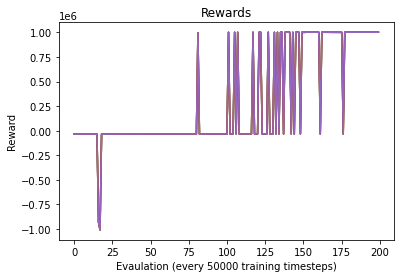

In [4]:
print(eval['results'])
plt.plot(eval['results'])
plt.title('Rewards')
plt.xlabel('Evaulation (every 50000 training timesteps)')
plt.ylabel('Reward')


# The Environment and Model Loading for evaluation

In [5]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import PIL.Image as Image
import random
import gym

from gym import Env, spaces, wrappers
import time
from stable_baselines3 import DQN
#from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecTransposeImage, DummyVecEnv

font = cv2.FONT_HERSHEY_COMPLEX_SMALL 

In [6]:
class VehicleArea(Env):
    def __init__(self, four_only = True, train = True):
        super(VehicleArea, self).__init__()

        # Define action and observation space
        self.canvas_shape = (900, 900, 3)
        #self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
        #                                                high = np.ones(self.observation_shape),
        #                                                dtype = np.uint8)
        self.observation_shape = (45, 45, 3)
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape, dtype=np.uint8),
                                            high= 255*np.ones(self.observation_shape, dtype=np.uint8),
                                            dtype=np.uint8)


        

        # Define an action space ranging from 0 to 3 ## 8
        if four_only:
            self.action_space = spaces.Discrete(4)
        else:
            self.action_space = spaces.Discrete(8)

        self.train = train
        
        
        # Maximum fuel vehicle can take at once
        self.max_fuel = 1000

        # Define visted cells within the environment
        self.visited = []

        # Permitted area of the environment for the vehicle to not be placed out of bounds
        self.y_min = 0
        self.x_min = 0
        self.y_max = self.canvas_shape[0] #- 80
        self.x_max = self.canvas_shape[1] #- 80

                                
        # Create a canvas to render the environment images upon 
        self.canvas = np.ones(self.canvas_shape, dtype=np.uint8) * 255
    
    def draw_elements_on_canvas(self):
        # Init the canvas 
        self.canvas = np.ones(self.canvas_shape, dtype=np.uint8) * 255

        # Draw the elements on canvas
        for elem in self.visited:
            elem_shape = elem.icon.shape
            x,y = elem.x, elem.y
            self.canvas[y : y + elem_shape[1], x:x + elem_shape[0]] = elem.icon
        
        # Draw the vehicle on canvas
        self.canvas[self.vehicle.y : self.vehicle.y + self.vehicle.icon.shape[1], self.vehicle.x:self.vehicle.x + self.vehicle.icon.shape[0]] = self.vehicle.icon
        

        text = 'Fuel Left: {} | Return: {}'.format(self.fuel_left, self.ep_return)

        # Put the info on canvas 
        self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
                   0.8, (0,0,0), 1, cv2.LINE_AA)

    
    def reset(self):
        # Reset the fuel consumed
        self.fuel_left = self.max_fuel
    
        # Reset the reward
        self.ep_return  = 0

        # Number of visited cells
        self.visited_count = 0
    
        # Determine a place to intialise the vehicle in the environment (top left corner)
        x = random.randrange(int(0), int(self.observation_shape[0]), 90)
        y = random.randrange(int(0), int(self.observation_shape[1]), 90)
        
        # Intialise the vehicle
        self.vehicle = Vehicle("vehicle", self.x_max, self.x_min, self.y_max, self.y_min)
        self.vehicle.set_position(x,y)

        
    
        # Intialise the elements 
        self.visited = [] # self.vehicle

        spawned_visit = Visited("visit_{}".format(self.visited_count), self.x_max, self.x_min, self.y_max, self.y_min)
        self.visited_count += 1
        spawned_visit.set_position(self.vehicle.x, self.vehicle.y)
        self.visited.append(spawned_visit)
    
        # Reset the Canvas 
        self.canvas = np.ones(self.canvas_shape) * 255

        # Draw elements on the canvas
        self.draw_elements_on_canvas()
    
        # return the observation
        #return self.canvas 
        #cv2.imshow("resized",cv2.resize(self.canvas, (45,45)))
        return cv2.resize(self.canvas, (45,45))
        



    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            cv2.imshow("Area To Cover", self.canvas)
            cv2.waitKey(10)
        
        elif mode == "rgb_array":
            return self.canvas
        
    def close(self):
        cv2.destroyAllWindows()

    def get_action_meanings(self):
        return {0: "Right", 1: "Left", 2: "Down", 3: "Up"}#, 4: "Do Nothing"}

    def step(self, action):
        # Flag that marks the termination of an episode
        done = False
        reward = 0

        # Assert that it is a valid action 
        assert self.action_space.contains(action), "Invalid Action"

        # Decrease the fuel counter 
        self.fuel_left -= 1 


        # apply the action to the vehicle
        if action == 0:
            if self.vehicle.y < self.y_max:
                self.vehicle.move(0,90)
            else:
                reward += -1000
        elif action == 1:
            if self.vehicle.y > self.y_min + 90 -1:
                self.vehicle.move(0,-90)
            else:
                reward += -1000
        elif action == 2:
            if self.vehicle.x < self.x_max:
                self.vehicle.move(90,0)
            else:
                reward += -1000
        elif action == 3:
            if self.vehicle.x > self.x_min + 90 -1:
                self.vehicle.move(-90,0)
            else:
                reward += -1000
        elif action == 4:
            if self.vehicle.y < self.y_max and self.vehicle.x < self.x_max:
                self.vehicle.move(0,90)
                self.vehicle.move(90,0)
            else:
                reward += -1000
        elif action == 5:
            if self.vehicle.y > self.y_min + 90 -1 and self.vehicle.x < self.x_max:
                self.vehicle.move(0,-90)
                self.vehicle.move(90,0)
            else:
                reward += -1000
        elif action == 6:
            if self.vehicle.y < self.y_max and self.vehicle.x > self.x_min + 90 -1:
                self.vehicle.move(0,90)
                self.vehicle.move(-90,0)
            else:
                reward += -1000
        elif action == 7:
            if self.vehicle.y > self.y_min + 90 -1 and self.vehicle.x > self.x_min + 90 -1:
                self.vehicle.move(0,-90)
                self.vehicle.move(-90,0)
            else:
                reward += -1000

        # Check if the vehicle is visiting a new cell
        previously_visited = False
        for cell in self.visited:
            if self.vehicle.x == cell.x and self.vehicle.y == cell.y:
                previously_visited = True
                break

        if not previously_visited:                               
            spawned_visit = Visited("visit_{}".format(self.visited_count), self.x_max, self.x_min, self.y_max, self.y_min)
            self.visited_count += 1
            spawned_visit.set_position(self.vehicle.x, self.vehicle.y)
            self.visited.append(spawned_visit)
       

            # Reward for executing a step towards a new cell
            reward += 25
        else:
            # Reward for executing a step towards a previously visited cell 
            reward += -5
        
        

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        # If out of fuel, end the episode.
        if self.fuel_left == 0:
            done = True
            reward += -30000 # Penalty for running out of fuel before reaching the goal
        if self.train:
            if self.visited_count >= 90: # 90 for training
                done = True
                reward += 1000000 # Reward for reaching the goal
        else:
            if self.visited_count >= 90: # 99 for testing
                done = True
                reward += 1000000

        # Increment the episodic return
        self.ep_return += reward

        return cv2.resize(self.canvas, (45,45)), reward, done, {}
    
    
    #def clamp(self, n, minn, maxn):
    #    return max(min(maxn, n), minn)

        

In [7]:
class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.orientation = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name
    
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)
    
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y
        
        self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.icon_h)
    
    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

In [8]:
class Vehicle(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Vehicle, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("data/vehicle_ed.png") #/ 255.0 # , cv2.IMREAD_GRAYSCALE
        self.icon_w = 90
        self.icon_h = 90
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

class Visited(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Visited, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon_w = 90
        self.icon_h = 90
        self.icon = 125*np.ones((self.icon_w, self.icon_h, 3), dtype=np.uint8)
        self.icon[:,:,1] = 255
        self.icon[::20,::20,:] = 0
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

In [9]:
model = DQN.load("logs/4_actions/train_eval_eq_90/best_model")

In [10]:
env = VehicleArea(four_only =True, train = False)

In [11]:
from IPython import display
import time


obs = env.reset()


while True:
    action, _states = model.predict(obs, deterministic=True)
    #action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    
    # Render the game
    env.render()
    time.sleep(0.1)
    
    if done == True:
        print('reward= ',reward)
        print('fuel= ',env.fuel_left)
        break

env.close()

Qt: Session management error: Could not open network socket


reward=  1000025
fuel=  911
